**Configure Compute Devices**

In [1]:
# Use these parameters to choose which devices to use.
use_GPU = True
enabled_GPUs = [0,1]

# Set visible devices.
import os
#os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
#os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([str(gpu) for gpu in enabled_GPUs])

# Import device utils.
import sys
sys.path.append('./src/')
sys.path.append('./rcwa_pt/src/')
import utils

# Configure GPUs.
if (use_GPU): utils.config_gpu_memory_usage()

# Measure GPU memory usage.
gpu_memory_init = utils.gpu_memory_info()

**Dependencies**

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import solver_pt
import solver_metasurface_pt

**Configure Optimization Parameters**

In [3]:
# Initialize parameters.
user_params = {}

# Flag to enable hyperparameter grid search.
user_params['enable_hyperparameter_gridsearch'] = False

# Tunable parameters.
# These are the values used if hyperparameter grid search is disabled.
user_params['N'] = 10
user_params['sigmoid_update'] = 5.0
user_params['learning_rate'] = 6E-2
user_params['initial_height'] = 3

user_params['parameter_string'] = 'N' + str(user_params['N']) \
    + '-sigmoid_update' + str(user_params['sigmoid_update']) \
    + '-learning_rate' + str(user_params['learning_rate']) \
    + '-initial_height' + str(user_params['initial_height'])

# Values to use in hyperparameter grid search.
# Stored as a dict. Each dict key is the key in user_params corresponding to a tunable
# hyperparameter, i.e. 'N', and its value is a list of values to try for that hyperparameter.
param_grid = {'N': [2],
              'sigmoid_update': [10.0, 20.0, 40.0],
              'learning_rate': [2E-1, 4E-1, 8E-1],
              'initial_height': [0]}
user_params['param_grid'] = param_grid


# Source parameters.
user_params['wavelengths'] = [158.0]
user_params['thetas'] = [0.0]
user_params['phis'] = [0.0]
user_params['pte'] = [1.0]
user_params['ptm'] = [0.0]

# Device parmeters.
user_params['pixelsX'] = 180
user_params['pixelsY'] = user_params['pixelsX']
user_params['erd'] = 11.9
user_params['ers'] = user_params['erd']
user_params['L'] = [50.0, 50.0, 50.0, 50.0, 50.0, 250.0]
user_params['Lx'] = 5000.0 / user_params['pixelsX']
user_params['Ly'] = user_params['Lx']
user_params['f'] = 30000.0 # Focal distance (um)

# Solver parameters.
user_params['PQ'] = [3,3]
user_params['upsample'] = 11

# Problem parameters.
user_params['w_l1'] = 1.0
user_params['sigmoid_coeff'] = 1.0
user_params['focal_spot_radius'] = 10
user_params['enable_random_init'] = False
user_params['enable_debug'] = False
user_params['enable_print'] = True
user_params['enable_timing'] = True

# Logging parameters.
user_params['enable_logging'] = True
user_params['log_filename_prefix'] = './results/nearfield-' + str(user_params['pixelsX']) + 'x' + str(user_params['pixelsY']) + '-'
user_params['log_filename_extension'] = '.txt'
user_params['load_result'] = False
user_params['load_filename'] = user_params['log_filename_prefix'] + user_params['parameter_string'] + user_params['log_filename_extension']

**Loss Function Definition**

In [4]:
def loss_function(h, params):
    
    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface_pt.generate_layered_metasurface(h, params)

    # Simulate the system.
    outputs = solver_pt.simulate_allsteps(ER_t, UR_t, params)
    
    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver_pt.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = torch.sum(torch.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Final loss: (negative) field intensity at focal point + field intensity elsewhere.
    return -params['w_l1']*l1

**Perform Experiments**

In [5]:
# Set loss function.
user_params['loss_function'] = loss_function
    
# Optimize.
h, loss, params, focal_plane = solver_metasurface_pt.optimize_device(user_params)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, Done.


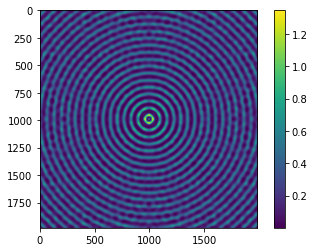

In [6]:
intensity = torch.abs(focal_plane[0, :, :]) ** 2
intensity = intensity.detach().cpu().numpy()
plt.imshow(intensity)
plt.colorbar()

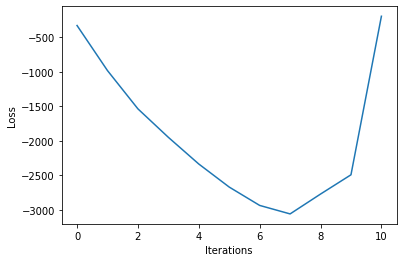

In [7]:
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

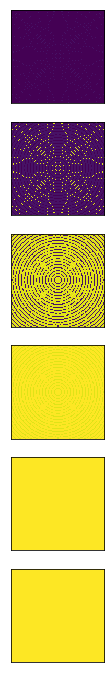

In [8]:
ER_t, UR_t = solver_metasurface_pt.generate_layered_metasurface(h, params)
solver_metasurface_pt.display_layered_metasurface(ER_t, params)

In [9]:
gpu_memory_final = utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [0, 45979]
